In [1]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import os
import time
import pandas as pd

In [2]:
base_path = "./dataset/dataset_augmented/test/images"
images = os.listdir(base_path)

In [3]:
checkpoint = '__models/06_RFCN_resnet101/frozen_inference_graph.pb'

min_confidence = 0.8
detection_graph = tf.Graph()
session = 0

times = []
bboxes = []

with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()  # CHANGED -- instead of tf.GraphDef()

    # CHANGED -- instead of :: with tf.gfile.GFile(self.checkpoint, 'rb') as fid:
    with tf.compat.v2.io.gfile.GFile(checkpoint, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    # CHANGED -- instead of :: tf.Session(graph=self.detection_graph)
    session = tf.compat.v1.Session(graph=detection_graph)

for idx, img in enumerate(images):
    image = cv.imread(os.path.join(base_path, img))

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection
    start = time.time()
    (boxes, scores, classes, num_detections) = session.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded}
    )
    end = time.time()

    times.append(end - start)
    print("[INFO] {:.6f} for image".format(
        end - start) + f" {idx + 1}/{len(images)}")

    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    # faces = []
    im_height, im_width, _ = image.shape

    min_confidence = min_confidence if min_confidence is not None else min_confidence

    current_boxes = []

    for i in range(boxes.shape[0]):
        if scores[i] >= min_confidence:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)

            x, y, w, h = int(left), int(top), int(
                right - left), int(bottom - top)

            current_boxes.append([x, y, x+w, y+h])
            # faces.append([x, y, w, h, scores[i]])
            # faces.append([x, y, w, h])
            # color = (0, 255, 0)
            # draw_face(image, (x, y, w, h), color)

    bboxes.append(current_boxes)


[INFO] 3.998000 for image 1/790
[INFO] 0.263999 for image 2/790
[INFO] 0.280499 for image 3/790
[INFO] 0.274001 for image 4/790
[INFO] 0.282501 for image 5/790
[INFO] 0.277501 for image 6/790
[INFO] 0.279500 for image 7/790
[INFO] 0.264499 for image 8/790
[INFO] 0.265998 for image 9/790
[INFO] 0.268000 for image 10/790
[INFO] 0.296001 for image 11/790
[INFO] 0.273499 for image 12/790
[INFO] 0.277499 for image 13/790
[INFO] 0.269500 for image 14/790
[INFO] 0.277000 for image 15/790
[INFO] 0.260500 for image 16/790
[INFO] 0.267000 for image 17/790
[INFO] 0.274498 for image 18/790
[INFO] 0.273001 for image 19/790
[INFO] 0.276500 for image 20/790
[INFO] 0.271500 for image 21/790
[INFO] 0.285000 for image 22/790
[INFO] 0.264999 for image 23/790
[INFO] 0.271501 for image 24/790
[INFO] 0.281500 for image 25/790
[INFO] 0.285500 for image 26/790
[INFO] 0.280501 for image 27/790
[INFO] 0.275000 for image 28/790
[INFO] 0.291001 for image 29/790
[INFO] 0.277501 for image 30/790
[INFO] 0.278001 for

In [4]:
import pandas as pd
import numpy as np

p_images = []
p_times = []
p_x1 = []
p_y1 = []
p_x2 = []
p_y2 = []

for p_image, p_time, p_bbox in zip(images, times, bboxes):

    # No Bbox
    if len(p_bbox) == 0:
        p_images.append(p_image)
        p_times.append(p_time)

        p_x1.append(np.NAN)
        p_y1.append(np.NAN)
        p_x2.append(np.NAN)
        p_y2.append(np.NAN)

    # Bbox
    for box in p_bbox:
        # TODO :: Adjust format (x1, y1, ?, ?)
        p_images.append(p_image)
        p_times.append(p_time)

        p_x1.append(box[0])
        p_y1.append(box[1])
        p_x2.append(box[2])
        p_y2.append(box[3])

df = pd.DataFrame(list(zip(p_images, p_times, p_x1, p_y1, p_x2, p_y2)), columns=[
                  "Image", "Time", "X1", "Y1", "X2", "Y2"])
df

,Image,Time,X1,Y1,X2,Y2
0,1001_jpg.rf.b7c44a27e79dbc4de661327ba01c1edd.jpg,3.998000,229,151,464,534
1,1005_jpg.rf.bb3f3203348f9e88224f7467ef52843c.jpg,0.263999,247,146,487,422
2,1005_jpg.rf.bb3f3203348f9e88224f7467ef52843c.jpg,0.263999,140,114,190,176
3,1014_jpg.rf.c539a1eadeef2d13f1bf7d0f7b5c254c.jpg,0.280499,166,102,340,387
4,1061_jpg.rf.44dd02d8bd98efc8deac4f6fbc60ef99.jpg,0.274001,199,47,279,201
...,...,...,...,...,...,...
1234,986_jpg.rf.6f8ff4f13b76e435399fe4d604c285b3.jpg,0.279001,265,133,491,512
1235,987_jpg.rf.dff0e90c55a7621864aee639fd482d98.jpg,0.283000,233,155,291,256
1236,987_jpg.rf.dff0e90c55a7621864aee639fd482d98.jpg,0.283000,327,91,404,217
1237,98_jpg.rf.c929bd3c5be065cfdc29dfe04ff72d87.jpg,0.271500,276,196,368,367


1148_jpg.rf.02b4f42bf07950906637f830582e835b.jpg
180 89 480 383


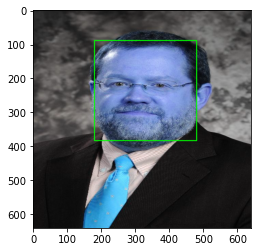

In [5]:
image_names = np.unique(df.Image)
current_entry = image_names[8] # "1_jpg.rf.e3e0a48dd72710db0188e9c100a49f5f.jpg" # 
print(current_entry)

current_df = df[df['Image'] == current_entry]

# Read image from your local file system
testImage = cv.imread(os.path.join(base_path, current_entry))

for df_idx, row in current_df.iterrows():
    if np.isnan(row['X1']):
        continue

    x1 = int(row['X1'])
    y1 = int(row['Y1'])
    x2 = int(row['X2'])
    y2 = int(row['Y2'])

    print(x1, y1, x2, y2)

    cv.rectangle(
        testImage,
        (x1, y1),
        (x2, y2),
        (0, 255, 0),
        2
    )

plt.figure(figsize=(4, 4))
plt.imshow(testImage)
plt.show()


In [6]:
model_name = "R-FCN"

folder_path = f"./test_results/{model_name}"
os.mkdir(folder_path)

results_path = f"./test_results/{model_name}.xlsx"


df.to_excel(results_path, index=False)